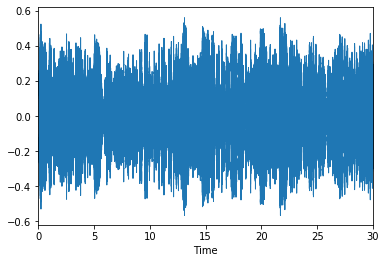

In [12]:
import glob, librosa, warnings
from math import ceil
from matplotlib import pyplot as plt
import librosa.display
import numpy as np 

warnings.filterwarnings("ignore")


class ParamsR:

    audio_len = 30
    srt = 22050 # default sample rate
    wsz = 4096            
    mels = 128
    hop_length = wsz // 2 
    feat_len = int(ceil(srt * audio_len / float(hop_length)))

params = ParamsR
song_dir = '/Users/peetal/Documents/Github/spotify_analysis/HL_output/audio/'
fn = glob.glob('{}/*mp3'.format(song_dir))[0]

sid = fn.split('/')[-1].split('.')[0]
y, sample_rate = librosa.load(fn, sr=22050) 

song_len = len(y) / float(22050)
if song_len < params.audio_len / 2:
    # return -3  # less than a half
    pass

# wave form of the song
librosa.display.waveplot(y, sample_rate)

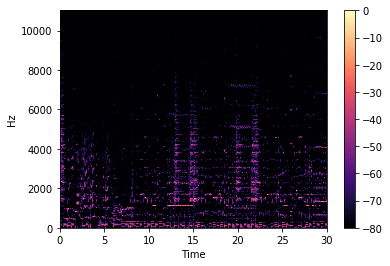

In [32]:
# spectrograms of the song -- linear frequency map 
# Not desire as all the action is in the bottome of the image -- fix with log-frequency 
D = librosa.stft(y) # short time fourier transform 
log_power = librosa.amplitude_to_db(D**2, ref=np.max)
librosa.display.specshow(log_power, x_axis = 'time', y_axis = 'linear')
plt.colorbar()


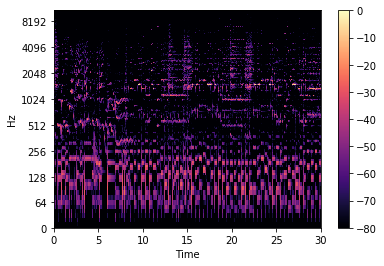

In [69]:
# spectrograms of the song -- log frequency map 
D = librosa.stft(y) # short time fourier transform 
log_power = librosa.amplitude_to_db(D**2, ref=np.max)
librosa.display.specshow(log_power, x_axis = 'time', y_axis = 'log')
plt.colorbar()


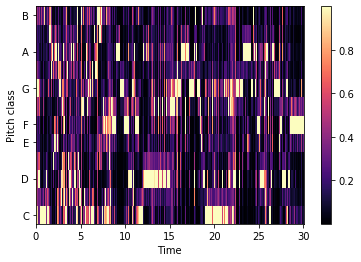

In [23]:
# spectral features: 
# Chroma measures the energy in each pitch class (e.g., C)
chroma = librosa.feature.chroma_stft(y, sr = sample_rate)
librosa.display.specshow(chroma, x_axis = 'time', y_axis = 'chroma')
plt.colorbar()


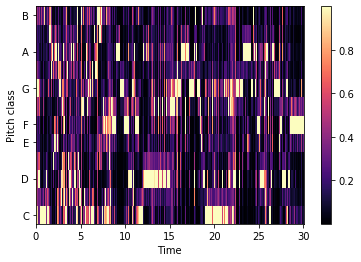

In [24]:
# constant-Q transform
C = librosa.cqt(y, sample_rate)
librosa.display.specshow(chroma, x_axis = 'time', y_axis = 'chroma')
plt.colorbar()

In [39]:
M = librosa.feature.melspectrogram(
        y=y, sr=params.srt, n_fft=params.wsz,
        hop_length=params.hop_length, n_mels=params.mels)

print(M.shape)
print(y.shape)

(128, 1294)
(662077,)


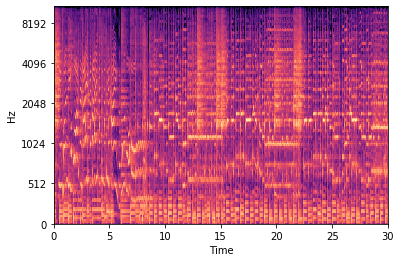

In [40]:
M_db = librosa.power_to_db(M,ref=np.max)
librosa.display.specshow(M_db, y_axis='mel', x_axis='time')

(128, 324)

Problems with vanilla spectrogram: Humans perceive frequency logarithmically

Mel (Melody) spectrograms: 
- Time-frequency representation 
- Perceptually-relevant amplitude representaion 
- Perceptally-relevant frequency representation 

Mel scale: 
- m = 2595 * log(1 + f/500)
- perceptually relevant scale for pitch 
- equal distances on the scale have same "perceptual" distance 

Convert frequencies to Mel scale: 
- choose number of mel bands -- could be a hyperparameter
- Construct mel filter banks -- take the frequency range in mel, and create equally space points set by number of mel bands. 
- Apply mel filter banks to spectrogram -- triangle filter 
- https://www.youtube.com/watch?v=9GHCiiDLHQ4

Mel spectrogram 
- M = (# bands, # frames)

In [49]:
def extract_melspec(in_fp, sr, win_size, hop_size, n_mels):
    sig, sr = librosa.core.load(in_fp, sr=sr)
    feat = librosa.feature.melspectrogram(sig, sr=sr,
                                          n_fft=win_size,
                                          hop_length=hop_size,
                                          n_mels=n_mels).T
    feat = np.log(1+10000*feat)
    return feat

import shutil

sr = 16000
win_sizes = [512,1024,2048,4096,8192,16384]
win_size = 512
hop_size = 512
n_mels = 128
diff_order = 0

if os.path.exists('jy_feat'):
    shutil.rmtree('jy_feat')
os.mkdir('jy_feat')

path = "HL_output/audio/" 
this_file = os.listdir(path)[0]
f = os.path.splitext(this_file)[0]
#print(f)
in_fp = path + this_file
print(in_fp)

feat = extract_melspec(in_fp, sr, win_size, hop_size, n_mels)

print(feat.shape)

HL_output/audio/0Ak8DtRldUO0ElPjgUM3Oh.mp3
(939, 128)


In [50]:
#path
feat_dir = '/Users/peetal/Documents/Github/spotify_analysis/mels'

#get files
fn_list = []
for files in os.listdir(feat_dir):
    if files.endswith('.npy'):
        fn_list.append(files)
fn_list.sort()

#make files
feat_fp_list = [os.path.join(feat_dir, fn) for fn in fn_list]

In [80]:
def _append_zero_row(array, n_total_row):
    r, c = array.shape
    if r >= n_total_row:
        return array
    else:
        temp = np.zeros((n_total_row-r, c))
        return np.vstack([array, temp])

def make_batch_feat(feat_fp_list, length=911):
    feat = []
    a_array = []
    feat_fp_list.sort()
    for idx, term in enumerate(feat_fp_list):
        # print(term)
        np.load(term)
        a_array = _append_zero_row(np.load(term), length)[None, None, :length, :].astype(floatX)
        feat.append(a_array)

    feat = np.vstack(feat)
    return feat

In [91]:
np.load(glob.glob("/Users/peetal/Documents/Github/spotify_analysis/jy_feat/out512/*.npy")[200]).shape

(939, 128)

In [84]:
_append_zero_row(array_test, 911)[None, None, :length, :].shape

(1, 1, 911, 128)

In [13]:
test = np.load('./ex_data/feat_test_512.npy')
test.shape

(343, 1, 939, 128)

In [14]:
test = np.load('./mels/00A0BGtwcWUpsCk8hqEKBE.npy')
test.shape

(1, 128, 323)

In [94]:
def standardize(feat, scaler=None):
    if scaler is None:
        scaler = pp.StandardScaler().fit(feat)
    out = scaler.transform(feat)
    return out, scaler

In [96]:
k = test.shape[-1]
n = test.shape[0]
test = test.reshape((-1, k))
test_s, scaler = standardize(test)
test_s = test_s.reshape((n, 1, -1, k))

In [99]:
test.shape

(322077, 128)

In [127]:
from sklearn import preprocessing as pp
this_array = np.array([[1., 1.],
                       [2., 2.],
                       [3., 3.],
                       [4., 4.],
                       [5., 5.],
                       [6., 6.],
                       [7., 7.]])
scaler = pp.StandardScaler().fit(this_array)

In [128]:
scaler.transform(this_array)

array([[-1.5, -1.5],
       [-1. , -1. ],
       [-0.5, -0.5],
       [ 0. ,  0. ],
       [ 0.5,  0.5],
       [ 1. ,  1. ],
       [ 1.5,  1.5]])

In [5]:
print(os.path.expanduser('~/.theanorc.txt'))

/Users/peetal/.theanorc.txt


SyntaxError: invalid syntax (<ipython-input-2-940c5650677d>, line 1)

In [5]:
import theano
import theano.tensor as T
from theano.tensor.signal.pool import pool_2d
from lasagne import layers
import numpy as np
from clip2frame import utils, measure
import network_structure as ns
import os
import json
import ast

#gpu usage
#import theano.sandbox.cuda
#theano.sandbox.cuda.use("gpu3")

In [8]:
check_tag = np.load('/Users/peetal/Documents/Github/spotify_analysis/test_data/tgte.jynet.npy')

In [11]:
check_tag.shape

(343, 50)